# Analysis on Grouped HealthCodes Gait Features

This notebook explores the gait features of grouped healthcodes coming from the active tests of Sage Bionetowrks mPower App and controls from ElevateMS study cohort. The goal of this notebook is to further understand how gait features on PD and non-PD varies accross different demographics cohort. The pipeline of how we retrieve this feature sets is documented on a repostitory of this github repository: <b>http://github.com/arytontediarjo/mpower-gait-analysis</b>. 

### Table of Contents:

##### 1. Introduction

##### 2. Raw Probability Distribution Visualization of Treatment and Control Groups

##### 3. Baseline Prediction and Embedded Feature Importances

##### 4. EDA on Important Features

## 1. Introduction

#### Explaining the Features:

So in our gait analysis, all the features will be annotated as following:
    
     (aggregation_type)_(axis)_(name of feature) 
    
Several aggregation types are chosen based on several aspects:
    
    - `median`: Due to its insensitivy to outliers in getting the general overview of the features
    - `amax`: For capturing the "ON" phase of PD
    - `valrange`: For capturing the difference between "ON" and "OFF" phase of a PD
    - `iqr`: For capturing a more balanced difference between "ON" and "OFF" phase of a PD
    
#### Feature Descriptions:

- <b> Cadence </b>: Number of heel strikes per seconds
- <b>Energy Freeze Index</b>: Power in freeze band (high frequency band)/ Power in locomotor band (lower frequency band) 
- <b>Locomotor Freeze Index</b>: Power in freeze band (high frequency band) + Power in locomotor band (lower frequency band)
- <b>Average step/stride duration</b>: The average time duration between each step/stride
- <b>Std of step/Stride duration</b>: The standard deviation of time duration between each step/stride
- <b>Speed of gait</b>: gait speed from the energies of the approximation coefficients of wavelet functions
- <b>Step/stride regularity</b>: consistency of step/stride on a given x, y or z axis
- <b>Symmetry</b>: difference between step and stride regularity.
- <b>Rotation omega</b>: speed of turning (if it exists)    



#### Matched Users:

In our cohort anaysis, we will be using a matched healthcodes that has been subsampled to have no associations towards how likely they are to be PD or non-PD based on their own metadata (more information is addressed on the repo). Thus, by breaking the association of the metadata, our future models would not be dependent on what kind of metadata that the users might have. 

Link to matching documentation: https://github.com/arytontediarjo/mpower-gait-analysis/notebooks/matching_metadata.pdf

#### Notes:

"ON" phase and "OFF" phase indicates if they take medication or not

### Library Imports

In [2]:
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

#### Global Variables

In [3]:
WALKING_GROUPED_FEATURES = "syn21678699"
MATCHED_DEMOGRAPHICS = "syn21614563"
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



#### Helper Function

In [4]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_results_dataframe(X_test, y_test, *models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    data_dict["log-loss-test"] = []
    data_dict["f1-score-test"] = []
    for model in models:
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.NaN)
        y_true, y_pred = y_test, model.predict(X_test)
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_true, y_pred))
        data_dict["log-loss-test"].append(metrics.log_loss(y_true, y_pred))
        data_dict["f1-score-test"].append(metrics.f1_score(y_true, y_pred))
    data = pd.DataFrame(data_dict)
    return data

def visualize_feature_importances(X_train, *models):
    for model in models:
        try:
            features = model.best_estimator_["classifier"].feature_importances_
        except:
            features = model.best_estimator_["classifier"].coef_[0]

        series = np.abs(pd.Series(data = features, 
                            index = X_train.columns[model.best_estimator_["feature_selection"].get_support()]))\
                            .sort_values(ascending = True).tail(20)
        plt.figure(figsize = (8,5))
        plt.title("Feature Importances based base on %s"%type(model.best_estimator_["classifier"]).__name__)
        series.plot(kind = "barh")
        plt.show()

#### Get Gait Feature and Matched Demographic Datasets

In [33]:
# get data
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES )
demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS)


data = data[[feat for feat in data.columns if ("filepath" not in feat) 
             and ("window" not in feat) 
             and ("steps" not in feat) 
             and (feat != "index")
             and ("valrange" not in feat) 
             and ("consec_zero_cadence" not in feat)]]


# filter datasets
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

# merge inner
data = pd.merge(demographic[["healthCode"]], data, on = "healthCode", how = "inner")

# set healthcode as index
data = data.set_index("healthCode")

# clean sparse feature
data = data[data.columns[data.isnull().mean() < 0.2]]

# cols of choice
metadata_cols = ["test_type", "phoneInfo", "age", "gender", "table_version", "nrecords", "class"]
feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

## 2. Baseline Model using Performance Random Forests

- Null values are imputed by median
- Random Forest with 1000 subtrees are used for model fitting
- Check feature importances based on Random Forest Model

In [34]:
train = data[feat_cols]
target = data["class"].map({"PD":1, "control":0})

In [40]:
# Create raw model with 1000 estimators
model = RandomForestClassifier(n_estimators=50,
                              bootstrap = True,
                              random_state = 100)

# A simple median imputation on feature sets
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')


# split train test split
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                    test_size = 0.20,
                                                   random_state = 100)
imp_median.fit(X_train)
X_train = imp_median.transform(X_train)
model.fit(X_train, y_train)

X_test = imp_median.transform(X_test)
y_pred = model.predict(X_test)

#### Base RF-Model Performance

In [41]:
get_results_dataframe(X_test, y_test, model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,RandomForestClassifier,NaN,NaN,0.649303,11.978221,0.614232


#### Classification Report

In [25]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       159
           1       0.62      0.59      0.60       138

    accuracy                           0.64       297
   macro avg       0.64      0.64      0.64       297
weighted avg       0.64      0.64      0.64       297



#### Confusion Matrix

In [26]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), 
             index = ["predicted: 0", "predicted: 1"], 
             columns = ["true: 0", "true: 1"])

,true: 0,true: 1
predicted: 0,109,50
predicted: 1,57,81


It seems that our base model using random forest has some capability of recognizing users that are PD and those who are not from our studies in mPowerV1, mPowerV2 and ElevateMS.

#### Class Prediction Probability Distribution 

In [27]:
# get probability dataframe
proba = pd.DataFrame({"probability": model.predict_proba(X_test)[:,1], })
proba["class"] = y_test.reset_index(drop = True)

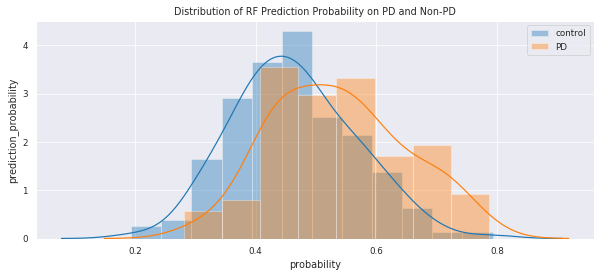

In [28]:
# plot probability distribution
plt.figure(figsize = (10,4))
sns.distplot(proba["probability"][proba["class"] == 0], label = "control")
sns.distplot(proba["probability"][proba["class"] == 1], label = "PD")
plt.legend()
plt.ylabel("prediction_probability")
plt.title("Distribution of RF Prediction Probability on PD and Non-PD")
plt.show()

The current base model shows that the model is still not able to perfectly separate between control and PD, however, we can see that our model is able to capture some signals by assigning higher prediction probability on the healthcodes that has PD.

#### Random Forest Embedded Feature Importances (Top 20)

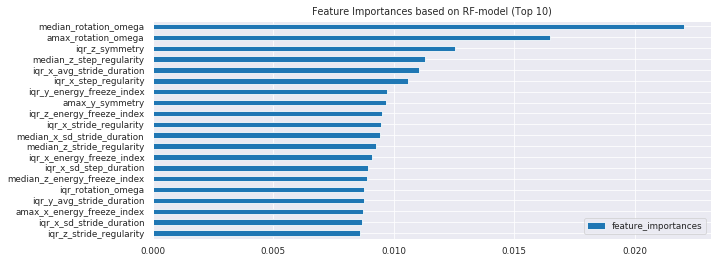

In [29]:
pd.DataFrame(data = model.feature_importances_, index = train.columns)\
.sort_values(0, ascending = True).tail(20).rename({0:"feature_importances"}, axis = 1).plot(kind = "barh", figsize = (10,4))
plt.title("Feature Importances based on RF-model (Top 10)")
plt.show()

The feature importances based on the tree model shows that rotation omega showcased a strong predictive power in reducing the entrophy of PD and Non-PDs as both aggregated features on rotation omega is shown to be the top 2 in terms of feature importances. IQR in gait symmetry, step regularities are also a signal that can be captured in PDs as the difference in "ON" and "OFF" phase can be captured by recognizing their signature gait motion compared to their irregular gait motion during "OFF" phase. 

### 4. EDAs on High Scoring Features

In [30]:
data["age_group"] = pd.cut(data["age"], bins = 4)

#### a. Median Rotation Speed over Older Age

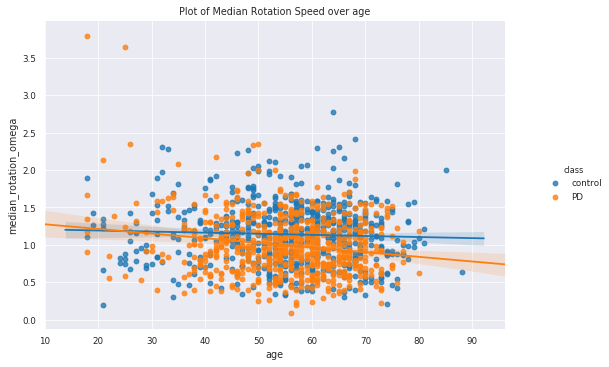

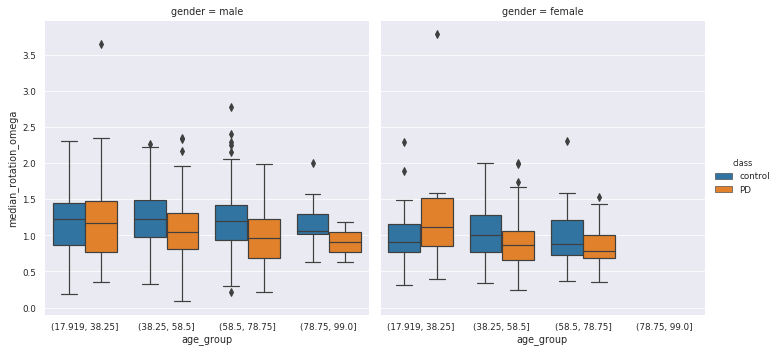

In [31]:
rotation = data[[feat for feat in data.columns if ("rotation_omega" in feat) or 
                       ("age" in feat) or ("gender" in feat) or ("class" in feat)]]
rotation  = rotation[rotation["median_rotation_omega"] > 0]


plot = sns.lmplot(y = "median_rotation_omega", x = "age", data = rotation, hue = "class")
plot.fig.set_size_inches(9,5)
plt.title("Plot of Median Rotation Speed over age")


cat = sns.catplot(y = "median_rotation_omega", x = "age_group", 
           data = rotation, col = "gender",
            hue = "class",
           kind = "box", height = 5)
plt.show()

The linear regression plot graph above shows that there are an interesting correlation on how PD patient have decrease of median rotation speed over age when compared to those of controls. 

The box plot shows that between the two groups of male and female, it can be seen that as you grow with age, the slower your rotation speed is, however, this is more drastic to those having PD as the <b> difference </b> of median rotation speed between controls and PD increas as you move on the age group.

### b. Increase in Average and Deviation of Stride-Stride Duration

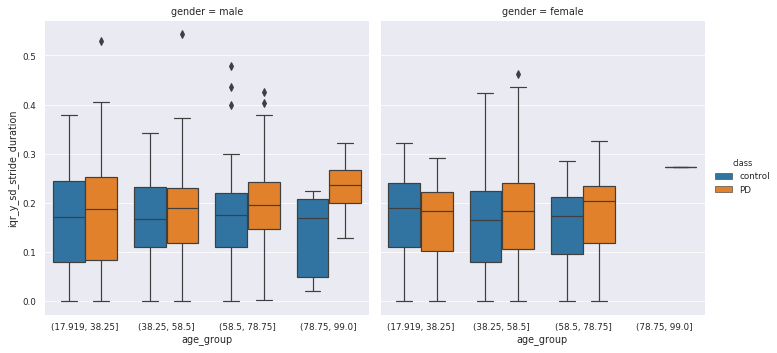

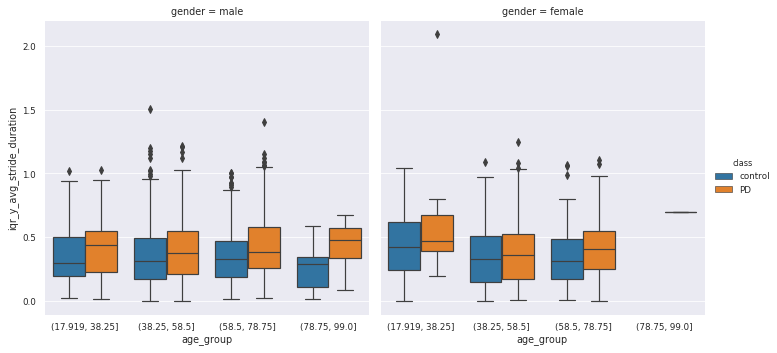

In [32]:
sns.catplot(y = "iqr_y_sd_stride_duration", x = "age_group", 
           data = data[["age_group", "iqr_y_sd_stride_duration", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)



sns.catplot(y = "iqr_y_avg_stride_duration", x = "age_group", 
           data = data[["age_group", "iqr_y_avg_stride_duration", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)

plt.show()


Strides are very interesting feature on assessing PD, as we can see in this boxplot, with older age groups (especialy the oldest age group), the male gender subgroups seemed to have a more drastic difference of interquartile range of standard deviation between each stride-stride duration between PD and Non-PD. However, the could not be said the same to the female gender group as we only have one female from our cohort in that age subgroup (based on the matched data)

### c. Median Stride Regularity

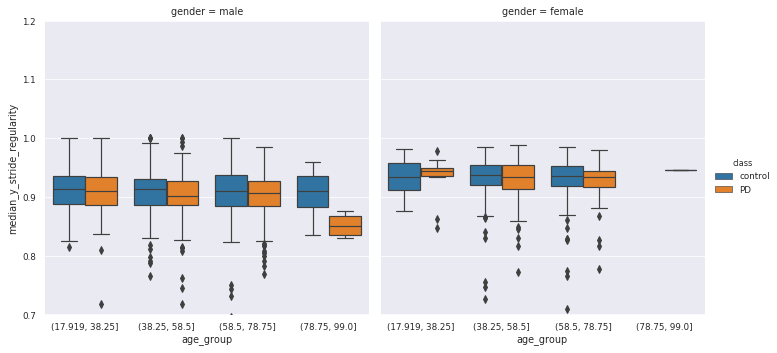

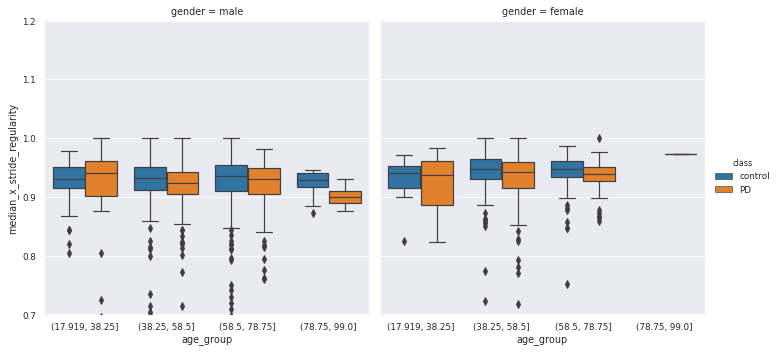

In [19]:
sns.catplot(y = "median_y_stride_regularity", x = "age_group", 
           data = data[["age_group", "median_y_stride_regularity", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)
plt.ylim(0.7,1.2)
plt.show()

sns.catplot(y = "median_x_stride_regularity", x = "age_group", 
           data = data[["age_group", "median_x_stride_regularity", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)
plt.ylim(0.7,1.2)
plt.show()


Median stride regularity on the different demographics seemed to have a trend as well as we can see that the median stride regularity, which measures how consistent the stride pattern is on the given axis seems to decrase as the age group increases. 

### d. Symmetry Interquartile Range on Different Demographics

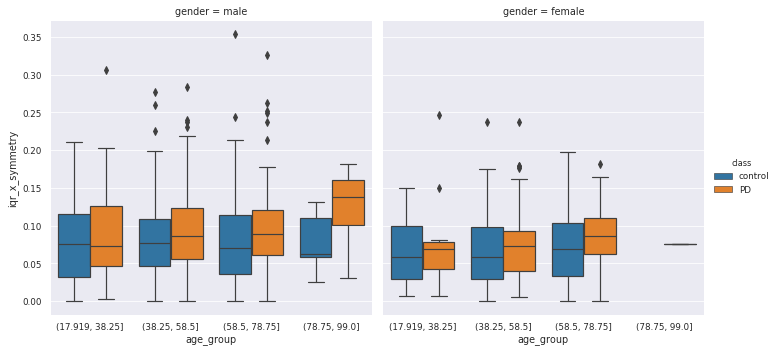

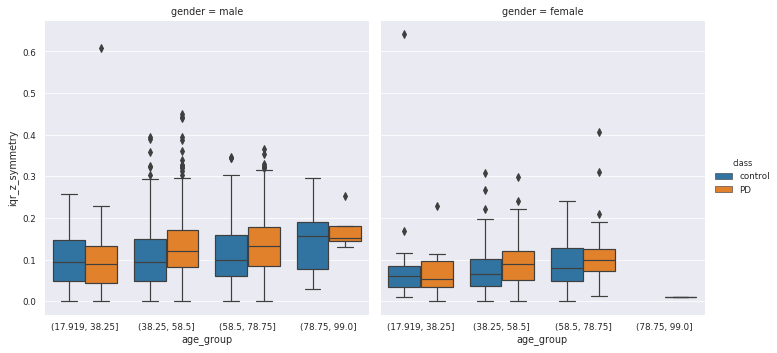

In [20]:
cat = sns.catplot(y = "iqr_x_symmetry", x = "age_group", 
           data = data[["age_group", "iqr_x_symmetry", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)

cat = sns.catplot(y = "iqr_z_symmetry", x = "age_group", 
           data = data[["age_group", "iqr_z_symmetry", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)

From the categorical plot above, we can see that both female-male groups have a monotonic increase in IQR of the symmetry in the z-axis and the x-axis respectively, with the exception of the last age group (78.75-99) as we only have one sample for that age group. 

This occurence could be caused due to the severity of the PD as the age group increases, the more likely you are walking less symmetric during the PD "ON" phase, which causes higher interquartile range as you subtract the symmetrical computation during the PD "OFF" phase.

### e. Freeze Index

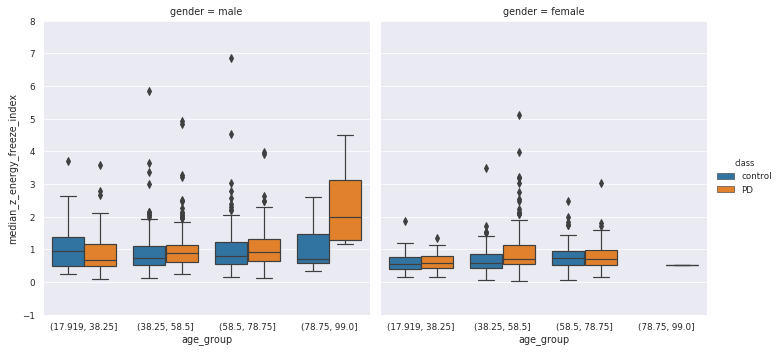

In [21]:
sns.catplot(y = "median_z_energy_freeze_index", x = "age_group", 
           data = data[["age_group", "median_z_energy_freeze_index", "class", "gender"]].dropna(), 
            col = "gender", hue = "class",
           kind = "box", height = 5)
plt.ylim(-1,8)
plt.show()

Median freeze index in the z axis seems to increase monotonically as it increases in age group, the last age group showcased how the difference of freeze index in the two groups vary greatly. However it seems that there are some effects of outliers in some of the younger age groups, which is an interesting analysis that we can explore further.

### Assessing Correlations between Gait Features

As we are using features that is based on aggregation, it is common to face highly correlated features.

In [22]:
print("Top Absolute Correlations")
get_top_abs_correlations(data[feat_cols], 20)

Top Absolute Correlations


amax_y_avg_number_of_strides  amax_y_cadence                  0.947290
amax_x_avg_number_of_strides  amax_x_cadence                  0.944284
median_x_loco_freeze_index    median_x_speed_of_gait          0.940646
median_z_loco_freeze_index    median_z_speed_of_gait          0.935539
median_AA_loco_freeze_index   median_AA_speed_of_gait         0.933736
iqr_AA_step_regularity        iqr_AA_stride_regularity        0.932986
median_y_loco_freeze_index    median_y_speed_of_gait          0.929094
amax_AA_loco_freeze_index     amax_y_loco_freeze_index        0.921078
amax_z_avg_number_of_strides  amax_z_cadence                  0.918605
median_AA_loco_freeze_index   median_y_loco_freeze_index      0.906832
median_AA_step_regularity     median_AA_stride_regularity     0.906222
median_AA_loco_freeze_index   median_x_loco_freeze_index      0.896119
amax_AA_step_regularity       amax_AA_stride_regularity       0.894801
amax_z_loco_freeze_index      amax_z_speed_of_gait            0.891298
amax_x

## Results:

- The results of our analysis shows that the PDKit features are able to capture signals on users that is PD or non-PD 
- Rotation speed are a very strong feature as it is able to score really high on both the median and max aggregation, and as it increases in age group, it is apparent that the rotation speed for non-PD is not decreasing as drastically as the ones that has PD
- Average and deviation of stride-stride duration seems to increase over increasing age group, especially on the PD group, which could happen due to more erratic pattern in their gait movement. 
- Regularity in an axis (consistency of movement direction in an axis) seems to decrease more drastically in PD group when compared to the non-PD
- Interquartile ranges are an interesting feature to capture due to its capability to capture "ON" and "OFF" phase of PD, as an example is on the interquartile of z-symmetry, which is one of the strongest feature for prediction. 
- Median freeze index also proves to be a feature that can be essential towards prediction as it is able to capture signals in increasing age groups.

From all the features above, we can see that the male groups seems to have more monotonic relationship as the age group increases, however we could not say the same to the female group as we lack female that exists in the last age subgroups based on the subsampling that we had done prior to this analysis. 

### Future Ideas:
- Try out feature combination for reducing redundant features
- Try other subsamples of metadata
- Gather more data samples from Android